# Utils Functions

## Show Scrollable

In [3]:
from ipywidgets import HTML
from IPython.display import display
from pprint import pformat


def show_scrollable(content, height="300px"):
    """
    Show scrollable box in Jupyter with preserved indentation and dark theme.
    """

    if not isinstance(content, str):
        content = pformat(content)

    html = f"""
    <div style="
        height: {height};
        overflow: auto;
        background-color: black;
        color: white;
        border: 1px solid #444;
        padding: 10px;
        font-family: monospace;
        white-space: pre;  /* <— THIS PRESERVES INDENTATION */
    ">
        {content}
    </div>
    """
    display(HTML(html))

## Inspect Safe Tensors

In [4]:
from pathlib import Path
import re
from safetensors.torch import load_file
import torch


def head_tensor(t: torch.Tensor, max_preview: int = 10) -> torch.Tensor:
    """
    Slice the first `max_preview` elements along every dimension.
    """
    slices = tuple(slice(0, min(dim, max_preview)) for dim in t.shape)
    return t[slices]


def natural_key(text):
    # Breaks text into chunks of digits and non-digits: "layers.10" → ["layers.", 10]
    return [int(s) if s.isdigit() else s for s in re.split(r"(\d+)", text)]


def inspect_safetensors(path: str | Path, max_preview: int = 5) -> str:
    """
    Return a readable, naturally sorted summary of a .safetensors file as a string.

    Args:
        path (str | Path): Path to the .safetensors file.
        max_preview (int): Max number of values to preview for small tensors.

    Returns:
        str: Formatted summary string.
    """
    path = Path(path).expanduser()
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")

    state_dict = load_file(path)
    sorted_items = sorted(state_dict.items(), key=lambda x: natural_key(x[0]))

    lines = [
        f"🔍 Inspecting {path.name} — {len(sorted_items)} tensors found:",
        "",  # adds a single blank line after title
    ]

    for name, tensor in sorted_items:
        lines.append(f"- {name}: shape={tuple(tensor.shape)}, dtype={tensor.dtype}")
        if tensor.ndim <= 2 and tensor.numel() < 100:
            preview = tensor.flatten()[:max_preview].tolist()
            lines.append(f"   preview: {preview}")

    return "\n".join(lines)


def inspect_tensor(path: str | Path, tensor_name: str, max_preview: int = 10) -> str:
    """
    Inspect a specific tensor by name in a .safetensors file.

    Args:
        path (str | Path): Path to the .safetensors file.
        tensor_name (str): Exact name of the tensor to inspect.
        max_preview (int): Number of values to preview.

    Returns:
        str: Information about the tensor or a message if not found.
    """
    path = Path(path).expanduser()
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")

    state_dict = load_file(path)

    if tensor_name not in state_dict:
        return f"❌ Tensor '{tensor_name}' not found in {path.name}"

    tensor = state_dict[tensor_name]
    info = [
        f"✅ Tensor '{tensor_name}' found in {path.name}:",
        f"   shape: {tuple(tensor.shape)}",
        f"   dtype: {tensor.dtype}",
    ]

    if tensor.ndim <= 2 and tensor.numel() > 0:
        preview = tensor.flatten()[:max_preview].tolist()
        info.append(f"   preview: {preview}")

    return "\n".join(info)


def inspect_tensor_with_preview(
    path: str | Path, tensor_name: str, max_preview: int = 10
) -> str:
    """
    Inspect a specific tensor by name in a .safetensors file.

    Args:
        path (str | Path): Path to the .safetensors file.
        tensor_name (str): Exact name of the tensor to inspect.
        max_preview (int): Number of values to preview per dimension.

    Returns:
        str: Detailed information about the tensor or a message if not found.
    """
    path = Path(path).expanduser()
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")

    state_dict = load_file(path)

    if tensor_name not in state_dict:
        return f"❌ Tensor '{tensor_name}' not found in {path.name}"

    tensor = state_dict[tensor_name]
    info = [
        f"✅ Tensor '{tensor_name}' found in {path.name}:",
        f"   shape: {tuple(tensor.shape)}",
        f"   dtype: {tensor.dtype}",
    ]

    if tensor.numel() > 0 and (
        torch.is_floating_point(tensor)
        or tensor.dtype
        in (torch.int8, torch.int16, torch.int32, torch.int64, torch.uint8)
    ):
        info.extend(
            [
                f"   min: {tensor.min().item():.4e}",
                f"   max: {tensor.max().item():.4e}",
                f"   mean: {tensor.float().mean().item():.4e}",
            ]
        )

        preview = head_tensor(tensor, max_preview).tolist()
        info.append(f"   preview (first {max_preview} per dimension):")
        info.append(f"{preview}")

    return "\n".join(info)


def inspect_tensor_with_preview_pretty(
    path: str | Path, tensor_name: str, max_preview: int = 10
) -> str:
    """
    Inspect a specific tensor by name in a .safetensors file.

    Args:
        path (str | Path): Path to the .safetensors file.
        tensor_name (str): Exact name of the tensor to inspect.
        max_preview (int): Number of values to preview per dimension.

    Returns:
        str: Detailed information about the tensor or a message if not found.
    """
    path = Path(path).expanduser()
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")

    state_dict = load_file(path)

    if tensor_name not in state_dict:
        return f"❌ Tensor '{tensor_name}' not found in {path.name}"

    tensor = state_dict[tensor_name]
    info = [
        f"✅ Tensor '{tensor_name}' found in {path.name}:",
        f"   shape: {tuple(tensor.shape)}",
        f"   dtype: {tensor.dtype}",
    ]

    if tensor.numel() > 0 and (
        torch.is_floating_point(tensor)
        or tensor.dtype
        in (torch.int8, torch.int16, torch.int32, torch.int64, torch.uint8)
    ):
        info.extend(
            [
                f"   min: {tensor.min().item():.4e}",
                f"   max: {tensor.max().item():.4e}",
                f"   mean: {tensor.float().mean().item():.4e}",
            ]
        )

        # Preview with newline for each top-level slice
        sliced = head_tensor(tensor, max_preview)
        if sliced.ndim >= 2:
            preview_rows = sliced[:max_preview]
            preview_str = "\n".join(str(row.tolist()) for row in preview_rows)
        else:
            preview_str = sliced[:max_preview].tolist().__str__()

        info.append(f"   preview (first {max_preview} rows/slices):\n{preview_str}")

    return "\n".join(info)


def inspect_tensor_anomalies(path: str | Path, check_nan_inf: bool = True) -> str:
    tensors = load_file(str(path))
    lines = [f"🔎 Inspecting: {path} ({len(tensors)} tensors)\n"]

    for name, tensor in tensors.items():
        shape = tuple(tensor.shape)
        dtype = str(tensor.dtype)
        msg = f"- {name}: shape={shape}, dtype={dtype}"

        try:
            t = (
                tensor.float()
                if tensor.dtype in [torch.bfloat16, torch.float16]
                else tensor
            )

            stats = []
            if check_nan_inf:
                if torch.isnan(t).any():
                    stats.append("❗ NaN")
                if torch.isinf(t).any():
                    stats.append("❗ Inf")

            if t.numel() > 0:
                if t.dtype.is_floating_point:
                    stats += [
                        f"min={t.min().item():.2e}",
                        f"max={t.max().item():.2e}",
                        f"mean={t.mean().item():.2e}",
                    ]
                elif t.dtype == torch.int32:
                    t_f = t.float()
                    stats += [
                        f"min={t.min().item():.2e}",
                        f"max={t.max().item():.2e}",
                        f"mean={t_f.mean().item():.2e}",
                    ]

            if "qzeros" in name and (t < 0).any():
                stats.append("⚠️ Negative qzero")

            if stats:
                msg += " | " + ", ".join(stats)

        except Exception as e:
            msg += f" ⚠️ Error: {e}"

        lines.append(msg)

    return "\n".join(lines)

# Inspecting Full Qwen2 Model

In [ ]:
model_name = "Qwen/Qwen2.5-72B"

from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    torch_dtype="meta",  # Loads architecture only, no weights
    local_files_only=True,
)

# Print layer names
for name, _ in model.named_parameters():
    print(name)

# Inspecting DS R1 Qwen Model - FULL MODEL

In [19]:
from transformers import AutoModelForCausalLM, AutoConfig

model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
config = AutoConfig.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

print(config)  # Full architecture details

Qwen2Config {
  "_name_or_path": "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151643,
  "hidden_act": "silu",
  "hidden_size": 1536,
  "initializer_range": 0.02,
  "intermediate_size": 8960,
  "max_position_embeddings": 131072,
  "max_window_layers": 21,
  "model_type": "qwen2",
  "num_attention_heads": 12,
  "num_hidden_layers": 28,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 10000,
  "sliding_window": null,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.46.0",
  "use_cache": true,
  "use_mrope": false,
  "use_sliding_window": false,
  "vocab_size": 151936
}



In [14]:
from transformers import AutoModelForCausalLM
from torchinfo import summary
import torch

# Load models
model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"

model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)

summary(model, input_size=(1, 128), dtypes=[torch.int64])

Layer (type:depth-idx)                             Output Shape              Param #
Qwen2ForCausalLM                                   [1, 2, 128, 128]          --
├─Qwen2Model: 1-1                                  [1, 2, 128, 128]          --
│    └─Embedding: 2-1                              [1, 128, 1536]            233,373,696
│    └─Qwen2RotaryEmbedding: 2-2                   [1, 128, 128]             --
│    └─ModuleList: 2-3                             --                        --
│    │    └─Qwen2DecoderLayer: 3-1                 [1, 128, 1536]            46,797,824
│    │    └─Qwen2DecoderLayer: 3-2                 [1, 128, 1536]            46,797,824
│    │    └─Qwen2DecoderLayer: 3-3                 [1, 128, 1536]            46,797,824
│    │    └─Qwen2DecoderLayer: 3-4                 [1, 128, 1536]            46,797,824
│    │    └─Qwen2DecoderLayer: 3-5                 [1, 128, 1536]            46,797,824
│    │    └─Qwen2DecoderLayer: 3-6                 [1, 128, 1536] 

In [18]:
import torch
from transformers import AutoModel


def print_model_weights(model, max_lines=None):
    """
    Print the model's weight tensors in the format:
    - layer_name: shape=(...), dtype=...

    Args:
        model (torch.nn.Module): The model to inspect.
        max_lines (int, optional): Limit the number of lines printed.
    """
    count = 0
    for name, param in model.named_parameters():
        print(f"{name}: shape={tuple(param.shape)}, dtype={param.dtype}")
        count += 1
        if max_lines and count >= max_lines:
            break


model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"

model = AutoModel.from_pretrained(model_name)
print_model_weights(model, max_lines=20)  # print only first 10 weights

embed_tokens.weight: shape=(151936, 1536), dtype=torch.float32
layers.0.self_attn.q_proj.weight: shape=(1536, 1536), dtype=torch.float32
layers.0.self_attn.q_proj.bias: shape=(1536,), dtype=torch.float32
layers.0.self_attn.k_proj.weight: shape=(256, 1536), dtype=torch.float32
layers.0.self_attn.k_proj.bias: shape=(256,), dtype=torch.float32
layers.0.self_attn.v_proj.weight: shape=(256, 1536), dtype=torch.float32
layers.0.self_attn.v_proj.bias: shape=(256,), dtype=torch.float32
layers.0.self_attn.o_proj.weight: shape=(1536, 1536), dtype=torch.float32
layers.0.mlp.gate_proj.weight: shape=(8960, 1536), dtype=torch.float32
layers.0.mlp.up_proj.weight: shape=(8960, 1536), dtype=torch.float32
layers.0.mlp.down_proj.weight: shape=(1536, 8960), dtype=torch.float32
layers.0.input_layernorm.weight: shape=(1536,), dtype=torch.float32
layers.0.post_attention_layernorm.weight: shape=(1536,), dtype=torch.float32
layers.1.self_attn.q_proj.weight: shape=(1536, 1536), dtype=torch.float32
layers.1.self_

In [15]:
from transformers import AutoModelForCausalLM

model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)

for name, module in model.named_modules():
    # if "layers" in name and "proj" in name:
    print(name, module)

 Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 1536)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
          (k_proj): Linear(in_features=1536, out_features=256, bias=True)
          (v_proj): Linear(in_features=1536, out_features=256, bias=True)
          (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
      )
    )
    (norm): Q

In [4]:
from transformers import AutoModelForCausalLM, AutoConfig

original_config = AutoConfig.from_pretrained("Qwen/Qwen1.5-1.8B")
print(original_config)  # Compare hidden_size, layers, etc.

Qwen2Config {
  "_name_or_path": "Qwen/Qwen1.5-1.8B",
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151643,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 5504,
  "max_position_embeddings": 32768,
  "max_window_layers": 21,
  "model_type": "qwen2",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "num_key_value_heads": 16,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": null,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.46.0",
  "use_cache": true,
  "use_sliding_window": false,
  "vocab_size": 151936
}



## Inspect Weights

### Peak Weights

In [65]:
from transformers import AutoModelForCausalLM
import torch.nn as nn

model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)


def inspect_layer(name, module):
    """Helper function to inspect a single layer"""
    print(f"\n--- Layer: {name} ---")
    print(f"Type: {type(module)}")

    # Check if it's a standard linear layer
    if isinstance(module, nn.Linear):
        print(f"  Weight shape: {module.weight.shape} (out_features, in_features)")
        if module.bias is not None:
            print(f"  Bias shape: {module.bias.shape}")
        print(f"  First weight values (3x3):\n{module.weight.data[:3, :3]}")

    # Check for common patterns in transformer layers
    if "q_proj" in name:
        print("  [This appears to be a query projection]")
    elif "k_proj" in name:
        print("  [This appears to be a key projection]")
    elif "v_proj" in name:
        print("  [This appears to be a value projection]")
    elif "o_proj" in name:
        print("  [This appears to be an output projection]")
    elif "gate_proj" in name or "up_proj" in name or "down_proj" in name:
        print("  [This appears to be a feed-forward layer component]")


# Iterate through all layers
for name, module in model.named_modules():
    # Skip very high-level modules to reduce output
    if len(name.split(".")) > 6:  # Adjust this number as needed
        continue

    # Only inspect certain types of layers
    if isinstance(module, nn.Linear) or "proj" in name or "attention" in name:
        inspect_layer(name, module)

# Additional inspection of the first layer's weights
print("\n=== Detailed First Layer Inspection ===")
for name, param in model.named_parameters():
    if "layers.0" in name and "weight" in name:
        print(f"\nParameter: {name}")
        print(f"Shape: {param.shape}")
        print(
            f"First few values:\n{param.data[:2, :5] if len(param.shape) > 1 else param.data[:5]}"
        )
        break


--- Layer: model.layers.0.self_attn.q_proj ---
Type: <class 'torch.nn.modules.linear.Linear'>
  Weight shape: torch.Size([1536, 1536]) (out_features, in_features)
  Bias shape: torch.Size([1536])
  First weight values (3x3):
tensor([[-0.0300,  0.0226,  0.0251],
        [-0.0177, -0.0050,  0.0713],
        [-0.0033, -0.0170,  0.0043]])
  [This appears to be a query projection]

--- Layer: model.layers.0.self_attn.k_proj ---
Type: <class 'torch.nn.modules.linear.Linear'>
  Weight shape: torch.Size([256, 1536]) (out_features, in_features)
  Bias shape: torch.Size([256])
  First weight values (3x3):
tensor([[-0.0645,  0.0148, -0.1377],
        [ 0.0254, -0.0625,  0.0957],
        [ 0.0068, -0.0386, -0.0035]])
  [This appears to be a key projection]

--- Layer: model.layers.0.self_attn.v_proj ---
Type: <class 'torch.nn.modules.linear.Linear'>
  Weight shape: torch.Size([256, 1536]) (out_features, in_features)
  Bias shape: torch.Size([256])
  First weight values (3x3):
tensor([[ 0.0123, -0

### Weight distribution

In [ ]:
from transformers import AutoModelForCausalLM
import torch.nn as nn
import torch
import pandas as pd
from IPython.display import display

model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)


def collect_layer_weight_stats(model):
    """
    Collect weight statistics (min, max, mean, std, sparsity) for each Linear layer in the model.
    """
    stats = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            weight = module.weight.data

            stats.append(
                {
                    "layer": name,
                    "type": "Linear",
                    "shape": tuple(weight.shape),
                    "min": weight.min().item(),
                    "max": weight.max().item(),
                    "mean": weight.mean().item(),
                    "std": weight.std().item(),
                    "zero_ratio": (weight == 0).float().mean().item(),
                }
            )

    return pd.DataFrame(stats)


# Run the analysis
df_stats = collect_layer_weight_stats(model)

# Show top 20 layers with highest sparsity
df_top_sparse = df_stats.sort_values("zero_ratio", ascending=False).head(20)

display(df_top_sparse)

,layer,type,shape,min,max,mean,std,zero_ratio
0,model.layers.0.self_attn.q_proj,Linear,"(1536, 1536)",-0.953125,0.960938,1.750172e-05,0.053037,0.0
1,model.layers.0.self_attn.k_proj,Linear,"(256, 1536)",-0.384766,0.394531,-8.440000e-05,0.061757,0.0
2,model.layers.0.self_attn.v_proj,Linear,"(256, 1536)",-0.159180,0.197266,-1.660858e-05,0.030817,0.0
3,model.layers.0.self_attn.o_proj,Linear,"(1536, 1536)",-0.597656,0.605469,3.382745e-06,0.046337,0.0
4,model.layers.0.mlp.gate_proj,Linear,"(8960, 1536)",-0.753906,0.660156,-4.833728e-07,0.038473,0.0
5,model.layers.0.mlp.up_proj,Linear,"(8960, 1536)",-0.457031,0.419922,-5.622278e-06,0.034311,0.0
6,model.layers.0.mlp.down_proj,Linear,"(1536, 8960)",-0.550781,0.519531,1.262973e-05,0.036591,0.0
7,model.layers.1.self_attn.q_proj,Linear,"(1536, 1536)",-0.386719,0.394531,-1.325980e-05,0.040712,0.0
8,model.layers.1.self_attn.k_proj,Linear,"(256, 1536)",-0.341797,0.406250,-3.723954e-05,0.053641,0.0
9,model.layers.1.self_attn.v_proj,Linear,"(256, 1536)",-0.217773,0.189453,3.042569e-05,0.031537,0.0


In [17]:
import torch
from transformers import AutoModelForCausalLM

# Load original model
model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)

# Choose a specific layer to inspect
layer = model.model.layers[0].mlp.gate_proj
weight = layer.weight.data  # shape: (8960, 1536)

# Simulate group-wise scaling
group_size = 128
num_groups = weight.shape[0] // group_size
qweight_sim = []
zero_ratios = []

for g in range(num_groups):
    start = g * group_size
    end = (g + 1) * group_size
    w_slice = weight[start:end, :]

    # Use 99th percentile as simulated scale
    scale = torch.quantile(w_slice.abs(), 0.99)
    scale = max(scale.item(), 1e-5)  # Avoid divide-by-zero

    # Simulate quantization
    scaled = w_slice / scale
    rounded = torch.round(scaled)

    # Simulate clamping to 4-bit range [0–15]
    q = torch.clamp(rounded, 0, 15)

    # Track zero ratio
    zero_ratio = (q == 0).float().mean().item()
    zero_ratios.append(zero_ratio)

print(f"Average zero ratio across groups: {sum(zero_ratios)/len(zero_ratios):.2%}")

Average zero ratio across groups: 91.43%


## Summary View

# LLAMA3 Models

In [1]:
from transformers import AutoModelForCausalLM, AutoConfig

original_config = AutoConfig.from_pretrained("meta-llama/Meta-Llama-3-8B")
print(original_config)  # Compare hidden_size, layers, etc.

OSError: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/meta-llama/Meta-Llama-3-8B.
401 Client Error. (Request ID: Root=1-683353fb-51039aed3df2f93708f1d9e0;d16a0d44-2fe3-471d-beec-565097c2ccd1)

Cannot access gated repo for url https://huggingface.co/meta-llama/Meta-Llama-3-8B/resolve/main/config.json.
Access to model meta-llama/Meta-Llama-3-8B is restricted. You must have access to it and be authenticated to access it. Please log in.

In [ ]:
from transformers import AutoModelForCausalLM, AutoConfig

original_config = AutoConfig.from_pretrained("meta-llama/Meta-Llama-3-70B")
print(original_config)  # Compare hidden_size, layers, etc.

Qwen2Config {
  "_name_or_path": "Qwen/Qwen1.5-1.8B",
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151643,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 5504,
  "max_position_embeddings": 32768,
  "max_window_layers": 21,
  "model_type": "qwen2",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "num_key_value_heads": 16,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": null,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.46.0",
  "use_cache": true,
  "use_sliding_window": false,
  "vocab_size": 151936
}



# DeepSeek V3 Models

In [12]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(
    "deepseek-ai/deepseek-v3",
    torch_dtype="meta",  # No memory/download used
    trust_remote_code=True,  # Required for DeepSeek
    local_files_only=False,  # Allow fetching config (tiny file)
)

# Print all layer names + shapes (fake tensors)
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")

ValueError: Loading deepseek-ai/deepseek-v3 requires you to execute the configuration file in that repo on your local machine. Make sure you have read the code there to avoid malicious use, then set the option `trust_remote_code=True` to remove this error.

In [13]:
from huggingface_hub import list_repo_files

files = list_repo_files("deepseek-ai/deepseek-v3")
print("Config files:", [f for f in files if f.endswith(".json")])

Config files: ['config.json', 'inference/configs/config_16B.json', 'inference/configs/config_236B.json', 'inference/configs/config_671B.json', 'model.safetensors.index.json', 'tokenizer.json', 'tokenizer_config.json']


In [ ]:
from transformers import AutoModelForCausalLM
from torchinfo import summary
import torch

# Load models
model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"

model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)

summary(model, input_size=(1, 128), dtypes=[torch.int64])

# Inspect Layer Files

In [58]:
import torch
from pathlib import Path
from project_config import DEEPSEEK_R1_DISTILL_QUANT_MODEL_OUTPUT_DIR as output_dir

layers_dir = output_dir / "quantized_layers"
print("Available files:", list(layers_dir.glob("*")))


# print("-" * 10)

Available files: [PosixPath('/home/xzhang/models/deepseek-r1-distill-qwen-1.5b-awq-scrooge-4bit-g128/quantized_layers/model.layers.0.self_attn.q_proj.pt'), PosixPath('/home/xzhang/models/deepseek-r1-distill-qwen-1.5b-awq-scrooge-4bit-g128/quantized_layers/model.layers.0.self_attn.k_proj.pt'), PosixPath('/home/xzhang/models/deepseek-r1-distill-qwen-1.5b-awq-scrooge-4bit-g128/quantized_layers/model.layers.0.self_attn.v_proj.pt')]


In [59]:
layer_file = "model.layers.0.self_attn.v_proj.pt"  # Change as needed
target_file = layers_dir / layer_file
data = torch.load(target_file)

display(data)

{'qweight': tensor([[  -1048576,          0,       -256,  ...,          0,     -65536,
             1048576],
         [     -8176,       4097,     -65280,  ...,       -256,          0,
              -65264],
         [     -4096,      -3840,   -1048576,  ...,        -16,         16,
              -65279],
         ...,
         [       -27,       -208,     -32255,  ...,     -15359,  -15593215,
                -253],
         [        -1,        -14,        -47,  ...,         -1,        -16,
                  -3],
         [   -908766,         -2,      -1242,  ...,        -32,        -46,
          1125134880]], dtype=torch.int32),
 'qzeros': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0],

## All Files - Shapes

In [6]:
import torch
from pathlib import Path
from project_config import DEEPSEEK_R1_DISTILL_QUANT_MODEL_OUTPUT_DIR

base_dir = DEEPSEEK_R1_DISTILL_QUANT_MODEL_OUTPUT_DIR / "quantized_layers"

# Iterate over all .pt files under quantized_layers
for pt_file in sorted(base_dir.glob("**/*.pt")):
    print("=" * 80)
    print(f"📦 File: {pt_file.relative_to(base_dir)}")
    print("-" * 80)

    try:
        data = torch.load(pt_file, map_location="cpu")
    except Exception as e:
        print(f"❌ Failed to load: {e}")
        continue

    if isinstance(data, torch.Tensor):
        print(f"Tensor shape: {data.shape}")
        print(f"Tensor dtype: {data.dtype}")

    elif isinstance(data, dict):
        for key, value in data.items():
            if isinstance(value, torch.Tensor):
                print(f"{key}: shape={tuple(value.shape)}, dtype={value.dtype}")
            else:
                print(f"{key}: non-tensor value (type={type(value).__name__})")

    else:
        print(f"Unknown object type: {type(data)}")

    print("=" * 80)

📦 File: model.layers.0.self_attn.k_proj.pt
--------------------------------------------------------------------------------
qweight: shape=(1536, 32), dtype=torch.int32
qzeros: shape=(12, 32), dtype=torch.int32
scales: shape=(12, 256), dtype=torch.float16
bias: shape=(256,), dtype=torch.float16
📦 File: model.layers.0.self_attn.q_proj.pt
--------------------------------------------------------------------------------
qweight: shape=(1536, 192), dtype=torch.int32
qzeros: shape=(12, 192), dtype=torch.int32
scales: shape=(12, 1536), dtype=torch.float16
bias: shape=(1536,), dtype=torch.float16
📦 File: model.layers.0.self_attn.v_proj.pt
--------------------------------------------------------------------------------
qweight: shape=(1536, 32), dtype=torch.int32
qzeros: shape=(12, 32), dtype=torch.int32
scales: shape=(12, 256), dtype=torch.float16
bias: shape=(256,), dtype=torch.float16


## Qweights

In [3]:
import os
import torch
from pathlib import Path


def inspect_qweights_in_dir(layer_dir: Path, zero_threshold: float = 0.9):
    """
    Inspect qweight statistics for all saved quantized layer files in a directory.

    Args:
        layer_dir (Path): Directory containing *.pt quantized layer files.
        zero_threshold (float): Warn if percentage of zeros in qweight exceeds this.
    """
    layer_dir = Path(layer_dir).expanduser()
    if not layer_dir.exists():
        raise FileNotFoundError(f"Directory not found: {layer_dir}")

    pt_files = sorted(layer_dir.glob("*.pt"))
    if not pt_files:
        print("❌ No .pt layer files found in directory.")
        return

    print(f"\n🔍 Inspecting {len(pt_files)} layer files in: {layer_dir}\n")

    for f in pt_files:
        try:
            state_dict = torch.load(f, map_location="cpu")
            qweight = state_dict.get("qweight", None)

            if qweight is None:
                print(f"⚠️  {f.name}: Missing `qweight` key.")
                continue

            zeros = (qweight == 0).sum().item()
            total = qweight.numel()
            zero_pct = zeros / total

            unique_vals = torch.unique(qweight)
            preview_vals = unique_vals.tolist()[:10]

            flag = "⚠️ HIGH ZERO RATIO!" if zero_pct > zero_threshold else "✅"

            # ✅ FIX: Convert tuple to string before formatting
            shape_str = str(tuple(qweight.shape))

            print(
                f"{f.name:<40} | shape: {shape_str:<20} | "
                f"zeros: {zero_pct:.2%} | unique[:10]: {preview_vals} {flag}"
            )
            print()
        except Exception as e:
            print(f"❌ {f.name}: Error loading or parsing file — {str(e)}")


if __name__ == "__main__":
    # Example usage — adjust this path if needed
    quantized_dir = Path("~/models/deepseek-awq-scrooge/quantized_layers")
    inspect_qweights_in_dir(quantized_dir)


🔍 Inspecting 11 layer files in: /home/xzhang/models/deepseek-awq-scrooge/quantized_layers

model.layers.0.mlp.down_proj.pt          | shape: (8960, 192)          | zeros: 0.80% | unique[:10]: [-2147483632, -2147483595, -2147478528, -2147477696, -2147471184, -2147463135, -2147351983, -2147342333, -2147286528, -2147270592] ✅

model.layers.0.mlp.gate_proj.pt          | shape: (1536, 1120)         | zeros: 1.48% | unique[:10]: [-2147483632, -2147483136, -2147482605, -2147477706, -2147469259, -2147458810, -2147454684, -2147411712, -2147409151, -2147405529] ✅

model.layers.0.mlp.up_proj.pt            | shape: (1536, 1120)         | zeros: 3.10% | unique[:10]: [-2143018463, -2130636768, -1877794043, -1861152494, -1861082576, -1860168944, -1859911150, -1859055340, -1844444879, -1843068415] ✅

model.layers.0.self_attn.k_proj.pt       | shape: (1536, 32)           | zeros: 4.22% | unique[:10]: [-2147465929, -2147286224, -2146239273, -2145711647, -2140118910, -2132942554, -2130898540, -213040314

In [4]:
import torch
from pathlib import Path

# Path to the file
base_dir = Path("/home/xzhang/models/deepseek-awq-scrooge/quantized_layers")
layer_file = "model.layers.0.self_attn.q_proj.pt"
target_file = base_dir / layer_file

# Load the file
data = torch.load(target_file, map_location="cpu")

print(f"\nContents of {layer_file}:")

if isinstance(data, dict):
    for key, value in data.items():
        if isinstance(value, torch.Tensor):
            print(f"  {key:<10} → shape: {tuple(value.shape)}, dtype: {value.dtype}")
        else:
            print(f"  {key:<10} → type: {type(value).__name__}")
else:
    print("File content is not a dict.")


Contents of model.layers.0.self_attn.q_proj.pt:
  qweight    → shape: (1536, 192), dtype: torch.int32
  qzeros     → shape: (12, 192), dtype: torch.int32
  scales     → shape: (12, 1536), dtype: torch.float16
  bias       → shape: (1536,), dtype: torch.float16


In [16]:
# check_quantization_efficiency.py
import torch
from pathlib import Path
import matplotlib.pyplot as plt
from project_config import DEEPSEEK_R1_DISTILL_QUANT_MODEL_OUTPUT_DIR


def analyze_quantization(file_path):
    data = torch.load(file_path)

    if not isinstance(data, dict):
        print("Error: Expected quantized layer dictionary")
        return

    print(f"\nAnalyzing {file_path.name}")
    print("-" * 50)

    # Extract parameters
    qweight = data["qweight"]  # shape: [in_features, out_features//8]
    scales = data["scales"]  # shape: [in_features//group_size, out_features]
    qzeros = data["qzeros"]  # shape: [in_features//group_size, out_features//8]

    group_size = qweight.shape[0] // scales.shape[0]
    print(f"Group size: {group_size}")
    print(f"Scales range: {scales.min().item():.4f} - {scales.max().item():.4f}")

    # Properly expand dimensions for broadcasting
    scales = scales.view(
        -1, group_size, scales.shape[-1]
    )  # [groups, group_size, out_features]
    scales = scales.transpose(1, 2)  # [groups, out_features, group_size]
    scales = scales.reshape(-1, scales.shape[-1])  # [groups*out_features, group_size]

    qzeros = qzeros.view(-1, 1, qzeros.shape[-1])  # [groups, 1, out_features//8]
    qzeros = qzeros.expand(-1, group_size, -1)  # [groups, group_size, out_features//8]
    qzeros = qzeros.reshape(-1, qzeros.shape[-1])  # [in_features, out_features//8]

    # Dequantize sample weights
    sample_qweight = qweight[:group_size]  # First group only for demo
    sample_qzeros = qzeros[:group_size]
    sample_scales = scales[:group_size]

    dequant_weight = (sample_qweight - sample_qzeros) * sample_scales
    print(
        f"Sample dequantized range: {dequant_weight.min().item():.4f} - {dequant_weight.max().item():.4f}"
    )

    # Check 4-bit utilization
    quantized_values = qweight.unique(sorted=True)
    print(f"Unique 4-bit values: {len(quantized_values)}/16")
    print(
        f"Value range: {quantized_values.min().item()} to {quantized_values.max().item()}"
    )

    # Plot first group's weights

    plt.hist(qweight[:group_size].cpu().flatten().numpy(), bins=16)
    plt.title("4-bit Weight Values (First Group)")
    plt.xlabel("Quantized Value")
    plt.ylabel("Frequency")
    plt.show()


if __name__ == "__main__":
    base_dir = DEEPSEEK_R1_DISTILL_QUANT_MODEL_OUTPUT_DIR / "quantized_layers"
    layer_file = "model.layers.0.self_attn.q_proj.pt"
    file = base_dir / layer_file

    print(file)
    analyze_quantization(base_dir / layer_file)

/home/xzhang/models/deepseek-r1-distill-qwen-1.5b-awq-scrooge-4bit-g128/quantized_layers/model.layers.0.self_attn.q_proj.pt

Analyzing model.layers.0.self_attn.q_proj.pt
--------------------------------------------------
Group size: 128
Scales range: 0.0072 - 0.1002


RuntimeError: shape '[-1, 128, 1536]' is invalid for input of size 18432

## QZeros

In [ ]:
import torch
from project_config import DEEPSEEK_R1_DISTILL_QUANT_MODEL_OUTPUT_DIR

base_dir = DEEPSEEK_R1_DISTILL_QUANT_MODEL_OUTPUT_DIR / "quantized_layers"
layer_file = "model.layers.0.self_attn.q_proj.pt"
file = base_dir / layer_file
data = torch.load(file)

# Inspect available keys
print("Available keys:", data.keys())

qzeros = data["qzeros"]
print("qzeros shape:", qzeros.shape)
print("qzeros dtype:", qzeros.dtype)
print(
    "qzeros stats — min:",
    qzeros.min().item(),
    "max:",
    qzeros.max().item(),
    "mean:",
    qzeros.float().mean().item(),
)

# Percent age zero values
zero_ratio = (qzeros == 0).float().mean().item()
print(f"qzeros zero ratio: {zero_ratio:.2%}")

# Preview
print("qzeros preview:\n", qzeros[:10, :10])

Available keys: dict_keys(['qweight', 'qzeros', 'scales', 'bias'])
qzeros shape: torch.Size([12, 192])
qzeros dtype: torch.int32
qzeros stats — min: 0 max: 285216768 mean: 2660141.0
qzeros zero ratio: 96.35%
qzeros preview:
 tensor([[        0,         0,         0,         0,         0,         0,
                 0,         0,         0,         0],
        [        0,         0,         0,         0,         0,         0,
                 0,         0,         0,         0],
        [        0,         0,         0,         0,         0,         0,
                 0,         0,         0,         0],
        [        0,         0,         0,         0,         0,         0,
                 0, 268439552,         0,         0],
        [        0,         0,         0,         0,         0,         0,
                 0,         0,         0,         0],
        [        0,         0,         0,         0,         0,         0,
                 0,         0,         0,         0],
 

In [ ]:
# check_quantization_efficiency.py
import torch
from pathlib import Path
import matplotlib.pyplot as plt


def analyze_quantization(file_path):
    data = torch.load(file_path)

    if not isinstance(data, dict):
        print("Error: Expected quantized layer dictionary (qweight, scales, qzeros)")
        return

    print(f"\nAnalyzing {file_path.name}")
    print("-" * 50)

    # Extract quantization parameters
    qweight = data["qweight"]
    scales = data["scales"]
    qzeros = data["qzeros"]
    group_size = scales.shape[0] * (qweight.shape[0] // scales.shape[0])

    print(f"Group size: {group_size}")
    print(f"Scales range: {scales.min().item():.4f} - {scales.max().item():.4f}")

    # Simulate dequantization
    dequant_weight = (qweight - qzeros) * scales
    print(
        f"Dequantized weight range: {dequant_weight.min().item():.4f} - {dequant_weight.max().item():.4f}"
    )

    # Check 4-bit utilization
    quantized_values = qweight.unique(sorted=True)
    print(f"Unique 4-bit values used: {len(quantized_values)}/16 possible")
    print(
        f"Value range: {quantized_values.min().item()} to {quantized_values.max().item()}"
    )

    # Plot value distribution
    plt.figure(figsize=(10, 4))
    plt.hist(qweight.cpu().flatten().numpy(), bins=50)
    plt.title(f"4-bit Weight Distribution\n{file_path.name}")
    plt.xlabel("Quantized Value")
    plt.ylabel("Frequency")
    plt.show()


if __name__ == "__main__":
    base_dir = Path("/home/xzhang/models/deepseek-awq-scrooge/quantized_layers")
    layer_file = "model.layers.0.self_attn.q_proj.pt"  # Change as needed
    analyze_quantization(base_dir / layer_file)

## Scales

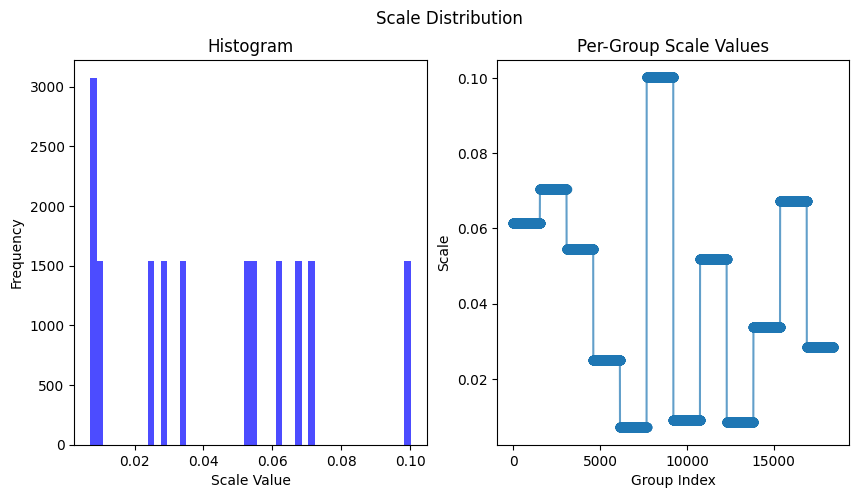

In [56]:
import torch
from project_config import DEEPSEEK_R1_DISTILL_QUANT_MODEL_OUTPUT_DIR
import matplotlib.pyplot as plt
import torch

base_dir = DEEPSEEK_R1_DISTILL_QUANT_MODEL_OUTPUT_DIR / "quantized_layers"
layer_file = "model.layers.0.self_attn.q_proj.pt"
file = base_dir / layer_file
state_dict = torch.load(file)

scales = state_dict["scales"]


def plot_scale_diagnostics(
    scales: torch.Tensor, title="Scale Distribution", save_path=None
):
    scales_np = scales.cpu().numpy().flatten()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.hist(scales_np, bins=50, color="blue", alpha=0.7)
    plt.title("Histogram")
    plt.xlabel("Scale Value")
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    plt.plot(scales_np, marker="o", linestyle="-", alpha=0.7)
    plt.title("Per-Group Scale Values")
    plt.xlabel("Group Index")
    plt.ylabel("Scale")

    plt.suptitle(title)

    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
        print(f"✅ Saved plot to: {save_path}")
    else:
        plt.show()


plot_scale_diagnostics(scales)

# Inspect Logs

In [2]:
def filter_log_file(input_file, output_file, keyword):
    try:
        with open(input_file, "r") as file:
            lines = file.readlines()

        filtered_lines = [line for line in lines if keyword not in line]

        with open(output_file, "w") as new_file:
            new_file.writelines(filtered_lines)

        print(f"Log file filtered successfully. Output saved to {output_file}")

    except FileNotFoundError:
        print(f"Input file {input_file} not found.")


log_file = "/home/xzhang/dev/deepseek_local_runner/documents/full_log_20250529_183204_resource.log"
filtered_log_file = "/home/xzhang/dev/deepseek_local_runner/documents/filtered_rcs.log"

# Usage
input_file = log_file
output_file = filtered_log_file
keyword = "[AutoMonitor]"

filter_log_file(input_file, output_file, keyword)

Log file filtered successfully. Output saved to /home/xzhang/dev/deepseek_local_runner/documents/filtered_rcs.log


# Inspect Saftetensors

## All Layers

In [29]:
from safetensors.torch import load_file
from pathlib import Path
from project_config import DEEPSEEK_R1_DISTILL_QUANT_MODEL_DIR


def inspect_safetensors_pretty(path: str | Path, max_preview: int = 5) -> list[str]:
    """
    Load and format .safetensors inspection results as a list of printable strings.

    Args:
        path (str | Path): Path to the .safetensors file.
        max_preview (int): Number of preview elements for small tensors.

    Returns:
        list[str]: Cleaned list of lines describing tensor structure and sample values.
    """
    path = Path(path).expanduser()
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")

    state_dict = load_file(path)
    lines = []
    lines.append(f"🔍 Inspecting {path.name} — {len(state_dict)} tensors found:")

    for name, tensor in state_dict.items():
        line = f"• {name}: shape={tuple(tensor.shape)}, dtype={tensor.dtype}"
        if tensor.ndim <= 2 and tensor.numel() < 100:
            preview = tensor.flatten()[:max_preview].tolist()
            line += f" | preview: {preview}"
        lines.append(line)

    return lines


tensor_file = DEEPSEEK_R1_DISTILL_QUANT_MODEL_DIR / "model.safetensors"
tensor_info = inspect_safetensors(tensor_file)

show_scrollable(tensor_info, height="400px")

HTML(value='\n    <div style="\n        height: 400px;\n        overflow: auto;\n        background-color: bla…

In [28]:
tensor_file = DEEPSEEK_R1_DISTILL_QUANT_MODEL_DIR / "model.safetensors"

summary = inspect_tensor(tensor_file, "model.layers.0.self_attn.o_proj.weight")
print(summary)

✅ Tensor 'model.layers.0.self_attn.o_proj.weight' found in model.safetensors:
   shape: (1536, 1536)
   dtype: torch.bfloat16
   preview: [-0.00151824951171875, 0.0012969970703125, -0.01141357421875, -0.046875, -0.0123291015625, -0.01519775390625, 0.01806640625, 0.0002899169921875, 0.021484375, -0.0076904296875]


In [60]:
import re
from safetensors.torch import load_file
from pathlib import Path


def natural_key(text):
    # Breaks text into chunks of digits and non-digits: "layers.10" → ["layers.", 10]
    return [int(s) if s.isdigit() else s for s in re.split(r"(\d+)", text)]


def inspect_safetensors(path: str | Path, max_preview: int = 5) -> None:
    """
    Print a readable, naturally sorted summary of a .safetensors file.

    Args:
        path (str | Path): Path to the .safetensors file.
        max_preview (int): Max number of values to preview for small tensors.
    """
    path = Path(path).expanduser()
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")

    state_dict = load_file(path)
    sorted_items = sorted(state_dict.items(), key=lambda x: natural_key(x[0]))

    print(f"\n🔍 Inspecting {path.name} — {len(sorted_items)} tensors found:\n")

    for name, tensor in sorted_items:
        print(f"- {name}: shape={tuple(tensor.shape)}, dtype={tensor.dtype}")
        if tensor.ndim <= 2 and tensor.numel() < 100:
            print(f"   preview: {tensor.flatten()[:max_preview].tolist()}")


tensor_file = Path(
    "~/models/deepseek-r1-distill-qwen-1.5b-awq-scrooge-4bit-g128/quantized_model/model.safetensors"
).expanduser()

inspect_safetensors(tensor_file)


🔍 Inspecting model.safetensors — 588 tensors found:

- model.layers.0.mlp.down_proj.qweight: shape=(8960, 192), dtype=torch.int32
- model.layers.0.mlp.down_proj.qzeros: shape=(70, 192), dtype=torch.int32
- model.layers.0.mlp.down_proj.scales: shape=(70, 1536), dtype=torch.float16
- model.layers.0.mlp.gate_proj.qweight: shape=(1536, 1120), dtype=torch.int32
- model.layers.0.mlp.gate_proj.qzeros: shape=(12, 1120), dtype=torch.int32
- model.layers.0.mlp.gate_proj.scales: shape=(12, 8960), dtype=torch.float16
- model.layers.0.mlp.up_proj.qweight: shape=(1536, 1120), dtype=torch.int32
- model.layers.0.mlp.up_proj.qzeros: shape=(12, 1120), dtype=torch.int32
- model.layers.0.mlp.up_proj.scales: shape=(12, 8960), dtype=torch.float16
- model.layers.0.self_attn.k_proj.bias: shape=(256,), dtype=torch.float16
- model.layers.0.self_attn.k_proj.qweight: shape=(1536, 32), dtype=torch.int32
- model.layers.0.self_attn.k_proj.qzeros: shape=(12, 32), dtype=torch.int32
- model.layers.0.self_attn.k_proj.s

In [ ]:
from safetensors import safe_open

required_keys = {"model.embed_tokens.weight", "lm_head.weight"}  # Example keys
tensor_file = Path(
    "~/models/deepseek-awq-scrooge/quantized_model/model.safetensors"
).expanduser()
with safe_open(tensor_file, framework="pt") as f:
    missing = required_keys - set(f.keys())
    if missing:
        print(f"WARNING: Missing critical weights: {missing}")

In [53]:
from safetensors import safe_open

tensor_file = Path(
    "~/models/deepseek-r1-distill-qwen-1.5b-awq-scrooge-4bit-g128/quantized_model/model.safetensors"
).expanduser()

with safe_open(tensor_file, framework="pt") as f:
    print(f"\n🔍 Total tensors: {len(f.keys())}")
    for key in f.keys():
        tensor = f.get_tensor(key)
        print(f"{key}: shape={tuple(tensor.shape)}, dtype={tensor.dtype}")


🔍 Total tensors: 588
model.layers.0.mlp.down_proj.qweight: shape=(8960, 192), dtype=torch.int32
model.layers.0.mlp.down_proj.qzeros: shape=(70, 192), dtype=torch.int32
model.layers.0.mlp.down_proj.scales: shape=(70, 1536), dtype=torch.float16
model.layers.0.mlp.gate_proj.qweight: shape=(1536, 1120), dtype=torch.int32
model.layers.0.mlp.gate_proj.qzeros: shape=(12, 1120), dtype=torch.int32
model.layers.0.mlp.gate_proj.scales: shape=(12, 8960), dtype=torch.float16
model.layers.0.mlp.up_proj.qweight: shape=(1536, 1120), dtype=torch.int32
model.layers.0.mlp.up_proj.qzeros: shape=(12, 1120), dtype=torch.int32
model.layers.0.mlp.up_proj.scales: shape=(12, 8960), dtype=torch.float16
model.layers.0.self_attn.k_proj.bias: shape=(256,), dtype=torch.float16
model.layers.0.self_attn.k_proj.qweight: shape=(1536, 32), dtype=torch.int32
model.layers.0.self_attn.k_proj.qzeros: shape=(12, 32), dtype=torch.int32
model.layers.0.self_attn.k_proj.scales: shape=(12, 256), dtype=torch.float16
model.layers.0

In [34]:
import json
from pathlib import Path


def inspect_config_types(config_path: str | Path) -> None:
    config_path = Path(config_path).expanduser()
    with open(config_path, "r", encoding="utf-8") as f:
        config = json.load(f)

    def print_types(d, prefix=""):
        for k, v in d.items():
            full_key = f"{prefix}.{k}" if prefix else k
            if isinstance(v, dict):
                print_types(v, prefix=full_key)
            else:
                print(f"{full_key}: {v} (type: {type(v)})")

    print(f"\n📁 Loaded config from: {config_path}")
    print_types(config)


# Example usage:
inspect_config_types(
    "~/models/deepseek-r1-distill-qwen-1.5b-awq-scrooge-4bit-g128/quantized_model/config.json"
)


📁 Loaded config from: /home/xzhang/models/deepseek-r1-distill-qwen-1.5b-awq-scrooge-4bit-g128/quantized_model/config.json
architectures: ['Qwen2ForCausalLM'] (type: <class 'list'>)
attention_dropout: 0.0 (type: <class 'float'>)
bos_token_id: 151643 (type: <class 'int'>)
eos_token_id: 151643 (type: <class 'int'>)
hidden_act: silu (type: <class 'str'>)
hidden_size: 1536 (type: <class 'int'>)
initializer_range: 0.02 (type: <class 'float'>)
intermediate_size: 8960 (type: <class 'int'>)
max_position_embeddings: 131072 (type: <class 'int'>)
max_window_layers: 21 (type: <class 'int'>)
model_type: qwen2 (type: <class 'str'>)
num_attention_heads: 12 (type: <class 'int'>)
num_hidden_layers: 28 (type: <class 'int'>)
num_key_value_heads: 2 (type: <class 'int'>)
quantization_config.q_group_size: 128 (type: <class 'int'>)
quantization_config.version: gemm (type: <class 'str'>)
quantization_config.w_bit: 4 (type: <class 'int'>)
quantization_config.zero_point: True (type: <class 'bool'>)
rms_norm_eps

## All Layers for Irregularities

In [50]:
from pathlib import Path
from safetensors.torch import load_file
from IPython.display import display, HTML
from pprint import pformat
import torch
import re


# 🧪 Example Usage
tensor_file = DEEPSEEK_R1_DISTILL_QUANT_MODEL_DIR / "model.safetensors"

tensor_info = inspect_tensor_anomalies(tensor_file)
show_scrollable(tensor_info, height="700px")

## Check o_proj layer

In [47]:
from safetensors.torch import load_file


tensor_file = Path(
    "~/models/deepseek-r1-distill-qwen-1.5b-awq-scrooge-4bit-g128/quantized_model/model.safetensors"
).expanduser()
tensor_dict = load_file(tensor_file)

layers = [f"model.layers.{i}.self_attn.o_proj.weight" for i in range(28)]

for name in layers:
    if name not in tensor_dict:
        print(f"❌ Missing: {name}")

In [ ]:
from safetensors.torch import load_file
from pathlib import Path

# Path to your model.safetensors file
tensor_file = Path(
    "~/models/deepseek-r1-distill-qwen-1.5b-awq-scrooge-4bit-g128/quantized_model/model.safetensors"
).expanduser()

# Load the tensor dictionary
tensor_dict = load_file(tensor_file)

# Build expected full-precision MLP layer weights
expected_fp_weights = [
    f"model.layers.{i}.{proj}.weight"
    for i in range(28)
    for proj in ["mlp.gate_proj", "mlp.up_proj", "mlp.down_proj"]
]

# Print missing ones
missing = [name for name in expected_fp_weights if name not in tensor_dict]
print(
    "✅ All expected MLP weights are present." if not missing else "❌ Missing weights:"
)
for name in missing:
    print(f"  - {name}")

In [35]:
from pathlib import Path
import json

config_path = Path(
    "/home/xzhang/models/deepseek-r1-distill-qwen-1.5b-awq-scrooge-4bit-g128/quantized_model/config.json"
)
with config_path.open("r", encoding="utf-8") as f:
    data = json.load(f)

print("\n🔍 Top-level keys:")
for k in data:
    print("-", k)

print("\n🔍 quantization_config block:")
print(data.get("quantization_config", "❌ Not found"))


🔍 Top-level keys:
- architectures
- attention_dropout
- bos_token_id
- eos_token_id
- hidden_act
- hidden_size
- initializer_range
- intermediate_size
- max_position_embeddings
- max_window_layers
- model_type
- num_attention_heads
- num_hidden_layers
- num_key_value_heads
- quantization_config
- rms_norm_eps
- rope_scaling
- rope_theta
- sliding_window
- tie_word_embeddings
- torch_dtype
- transformers_version
- use_cache
- use_mrope
- use_sliding_window
- vocab_size

🔍 quantization_config block:
{'q_group_size': 128, 'version': 'gemm', 'w_bit': 4, 'zero_point': True}


# Inspect Clips & Scales.py Files

In [57]:
import torch


tensor_file = DEEPSEEK_R1_DISTILL_QUANT_MODEL_DIR / "clips.pt"
# tensor_file = DEEPSEEK_R1_DISTILL_QUANT_MODEL_DIR / "scales.pt"

obj = torch.load(tensor_file)
print("Type:", type(obj))
print("Content:", obj)

Type: <class 'list'>
Content: []


# Inspect Hansen Quantized Model

In [1]:
from huggingface_hub import snapshot_download
from pathlib import Path

model_name = "casperhansen/deepseek-r1-distill-qwen-1.5b-awq"
local_dir = Path("~/models/casperhansen-deepseek-r1-distill-qwen-1.5b-awq").expanduser()

snapshot_download(repo_id=model_name, local_dir=str(local_dir))

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

'/home/xzhang/models/casperhansen-deepseek-r1-distill-qwen-1.5b-awq'

In [5]:
model_dir = Path("~/models/casperhansen-deepseek-r1-distill-qwen-1.5b-awq").expanduser()
tensor_file = model_dir / "model.safetensors"


# Display in scrollable box
tensor_info = inspect_tensor_anomalies(tensor_file)
show_scrollable(tensor_info, height="700px")

HTML(value='\n    <div style="\n        height: 700px;\n        overflow: auto;\n        background-color: bla…

## Inspect All

In [63]:
model_dir = Path("~/models/casperhansen-deepseek-r1-distill-qwen-1.5b-awq").expanduser()
tensor_file = model_dir / "model.safetensors"


print("q weights")
print(
    inspect_tensor_with_preview(
        tensor_file, "model.layers.12.mlp.gate_proj.qweight", max_preview=5
    )
)

print("\nscales")
print(
    inspect_tensor_with_preview(
        tensor_file, "model.layers.12.mlp.gate_proj.scales", max_preview=5
    )
)

print("\nzero points")
print(
    inspect_tensor_with_preview(
        tensor_file, "model.layers.12.mlp.gate_proj.qzeros", max_preview=5
    )
)

zero_ratio = (qzeros == 0).float().mean().item()

q weights
✅ Tensor 'model.layers.12.mlp.gate_proj.qweight' found in model.safetensors:
   shape: (1536, 1120)
   dtype: torch.int32
   min: -2.1475e+09
   max: 2.1475e+09
   mean: -5.1006e+07
   preview (first 5 per dimension):
[[-1533306763, 2087025544, 692627494, -1720351045, -1970759351], [2020056282, -1734774665, -1802487723, 1991667324, -1012423563], [1936371131, -1196127596, 982148987, 1404598931, -697714536], [-1717998971, -1955162004, 1958445400, 1665793879, -1134077114], [1952147082, -711421368, 1384789107, 1985490330, 1517852465]]

scales
✅ Tensor 'model.layers.12.mlp.gate_proj.scales' found in model.safetensors:
   shape: (12, 8960)
   dtype: torch.float16
   min: 4.3602e-03
   max: 9.9487e-02
   mean: 1.5744e-02
   preview (first 5 per dimension):
[[0.0227813720703125, 0.01666259765625, 0.01497650146484375, 0.016632080078125, 0.01477813720703125], [0.0286407470703125, 0.0124969482421875, 0.0119781494140625, 0.0100250244140625, 0.0153656005859375], [0.0159149169921875, 0.012

In [ ]:
model_dir = Path("~/models/casperhansen-deepseek-r1-distill-qwen-1.5b-awq").expanduser()
tensor_file = model_dir / "model.safetensors"

layer_name = "model.layers.12.mlp.gate_proj"


print("q weights")
print(
    inspect_tensor_with_preview(
        tensor_file, ".".join([layer_name, "qweight"]), max_preview=5
    )
)

print("\nscales")
print(
    inspect_tensor_with_preview(
        tensor_file, ".".join([layer_name, "scales"]), max_preview=5
    )
)

print("\nzero points")
print(
    inspect_tensor_with_preview(
        tensor_file, ".".join([layer_name, "qzeros"]), max_preview=5
    )
)

zero_ratio = (qzeros == 0).float().mean().item()

q weights
✅ Tensor 'model.layers.12.mlp.gate_proj.qweight' found in model.safetensors:
   shape: (1536, 1120)
   dtype: torch.int32
   min: -2.1475e+09
   max: 2.1475e+09
   mean: -5.1006e+07
   preview (first 5 per dimension):
[[-1533306763, 2087025544, 692627494, -1720351045, -1970759351], [2020056282, -1734774665, -1802487723, 1991667324, -1012423563], [1936371131, -1196127596, 982148987, 1404598931, -697714536], [-1717998971, -1955162004, 1958445400, 1665793879, -1134077114], [1952147082, -711421368, 1384789107, 1985490330, 1517852465]]

scales
✅ Tensor 'model.layers.12.mlp.gate_proj.scales' found in model.safetensors:
   shape: (12, 8960)
   dtype: torch.float16
   min: 4.3602e-03
   max: 9.9487e-02
   mean: 1.5744e-02
   preview (first 5 per dimension):
[[0.0227813720703125, 0.01666259765625, 0.01497650146484375, 0.016632080078125, 0.01477813720703125], [0.0286407470703125, 0.0124969482421875, 0.0119781494140625, 0.0100250244140625, 0.0153656005859375], [0.0159149169921875, 0.012

## Check for quant and unquantized layers dim - are they flipped

In [7]:
model_dir = Path("~/models/casperhansen-deepseek-r1-distill-qwen-1.5b-awq").expanduser()
tensor_file = model_dir / "model.safetensors"

layer_name = "model.layers.12.mlp.gate_proj.qweight"

print(inspect_tensor_with_preview(path=tensor_file, tensor_name=layer_name))

✅ Tensor 'model.layers.12.mlp.gate_proj.qweight' found in model.safetensors:
   shape: (1536, 1120)
   dtype: torch.int32
   min: -2.1475e+09
   max: 2.1475e+09
   mean: -5.1006e+07
   preview (first 10 per dimension):
[[-1533306763, 2087025544, 692627494, -1720351045, -1970759351, 1819972742, -2053719694, -1216207279, -2072332408, 1719171416], [2020056282, -1734774665, -1802487723, 1991667324, -1012423563, 2140497029, -1515945870, 2012382393, 174532521, -1420132987], [1936371131, -1196127596, 982148987, 1404598931, -697714536, -1989843094, -2018878714, 628652229, 1734781256, 1886038597], [-1717998971, -1955162004, 1958445400, 1665793879, -1134077114, 1753253563, -1450790212, 1939228842, 1785255831, -2055510122], [1952147082, -711421368, 1384789107, 1985490330, 1517852465, 429438815, -1431918808, -1751632758, 714958393, -1506712243], [-1705153991, 2009704072, 1662539930, -1791460989, 2069156508, -661223545, 650420589, -1550478267, -1749387351, 960783723], [-1721346629, -1436985448, -17

## Inspect Scales

In [ ]:
model_dir = Path("~/models/casperhansen-deepseek-r1-distill-qwen-1.5b-awq").expanduser()
tensor_file = model_dir / "model.safetensors"
layer_name = "model.layers.12.mlp.gate_proj.scales"

print("\nscales")
print(inspect_tensor_with_preview_pretty(tensor_file, layer_name, max_preview=20))


scales
✅ Tensor 'model.layers.12.mlp.gate_proj.scales' found in model.safetensors:
   shape: (12, 8960)
   dtype: torch.float16
   min: 4.3602e-03
   max: 9.9487e-02
   mean: 1.5744e-02
   preview (first 20 rows/slices):
[0.0227813720703125, 0.01666259765625, 0.01497650146484375, 0.016632080078125, 0.01477813720703125, 0.0119171142578125, 0.0177154541015625, 0.01666259765625, 0.023895263671875, 0.01409149169921875, 0.01763916015625, 0.017578125, 0.0164031982421875, 0.0128936767578125, 0.01380157470703125, 0.02044677734375, 0.0163116455078125, 0.01302337646484375, 0.013214111328125, 0.0212860107421875]
[0.0286407470703125, 0.0124969482421875, 0.0119781494140625, 0.0100250244140625, 0.0153656005859375, 0.0159454345703125, 0.0159149169921875, 0.027923583984375, 0.024810791015625, 0.01425933837890625, 0.0173187255859375, 0.0193939208984375, 0.0158233642578125, 0.0300140380859375, 0.0143890380859375, 0.0212249755859375, 0.0177764892578125, 0.0186920166015625, 0.0188751220703125, 0.01947021

In [ ]:
model_dir = Path("~/models/casperhansen-deepseek-r1-distill-qwen-1.5b-awq").expanduser()
tensor_file = model_dir / "model.safetensors"
layer_name = "model.layers.0.self_attn.q_proj.scales"

print("\nscales")
print(inspect_tensor_with_preview_pretty(tensor_file, layer_name, max_preview=20))


scales
✅ Tensor 'model.layers.0.self_attn.q_proj.scales' found in model.safetensors:
   shape: (12, 1536)
   dtype: torch.float16
   min: 2.2621e-03
   max: 1.3391e-01
   mean: 1.6508e-02
   preview (first 20 rows/slices):
[0.007080078125, 0.00823211669921875, 0.00600433349609375, 0.006870269775390625, 0.0078582763671875, 0.00939178466796875, 0.0090484619140625, 0.0058746337890625, 0.01351165771484375, 0.00798797607421875, 0.01123046875, 0.00891876220703125, 0.01230621337890625, 0.00548553466796875, 0.011260986328125, 0.010284423828125, 0.01331329345703125, 0.0077972412109375, 0.0126953125, 0.01549530029296875]
[0.00647735595703125, 0.00963592529296875, 0.00698089599609375, 0.00894927978515625, 0.00693511962890625, 0.009246826171875, 0.00969696044921875, 0.0068359375, 0.00885772705078125, 0.01139068603515625, 0.007503509521484375, 0.00989532470703125, 0.0080718994140625, 0.007633209228515625, 0.00894927978515625, 0.009307861328125, 0.009307861328125, 0.00791168212890625, 0.00916290283

In [ ]:
w_mean = [[[0.50], [0.50]], [[0.58], [0.61]], [[0.62], [0.54]], [[0.92], [0.62]]]

12.0